### RFC

### import modules and configure notebook

In [16]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [17]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats


In [18]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'

### I label encode the class column again because just bedrock is being classified and when class was label encoded in data reproccessing script label encoding was done for both bedrock sites and superficial regions

In [19]:
if classify_bedrock_only:
    
    test_data_superficial = train_data_formodel[train_data_formodel['Geology']=='Superficial']
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])

In [20]:
train_data_formodel.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,154.63,943.71,464944.18,50.28,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,22.42,1077.11,465010.94,70.91,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.70,620.21,465295.41,104.47,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,162.42,1143.19,465099.89,56367.93,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.52,547.22,465027.11,44.44,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


In [21]:
train_data_formodel.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238'], dtype=object)

In [22]:
uniques

Index(['FH1', 'FH2', 'FH3', 'ER', 'WW1', 'WW2', 'WW3', 'WW4', 'TC1', 'TC2',
       'CS1', 'CS2', 'CS3', 'BC', 'KQ1', 'KQ2', 'KQ3', 'AR1', 'AR2', 'AR3',
       'SL', 'FG', 'WB', 'BX', 'PF', 'BM', 'WH1', 'WH2', 'WH3', 'WH4', 'SQ2',
       'BP', 'WN1', 'WN5', 'WN6', 'BH1', 'BH2', 'BH3', 'BH4', 'PH', 'LB', 'AB',
       'LV', 'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH', 'PX',
       'WF'],
      dtype='object')

In [23]:
y = np.array(train_data_formodel['class'])

In [24]:
train_data_feats = train_data_formodel[train_data_formodel.columns.values[9:-1]]

In [25]:
train_data_feats.shape

(1243, 53)

### Turn feature data and class to be predicited into numpy arrays

In [26]:
X = np.array(train_data_feats)

In [27]:
print(X.shape)
print(y.shape)

(1243, 53)
(1243,)


### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores with weighted averages are calculated

In [28]:
RFC = RandomForestClassifier(n_estimators=2000, random_state=random_seed_state)
skf = StratifiedKFold(n_splits=5, random_state=random_seed_state)
skf.get_n_splits(X, y)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
feat_imp_dict = {}
count = 0
for train_index, test_index in skf.split(X, y):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict(X_test)
    class_f1_scores = f1_score(y_test, y_pred, average = None)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    feat_imp_dict[key] = RFC.feature_importances_

making model:
1


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
2


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
3


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
4


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
5


/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
f1_df = pd.DataFrame(data = f1_dict)


In [30]:
for key in f1_dict:
    print(len(f1_dict[key]))

55
55
55
55
55


### Below are the encodings for the class variable

In [31]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
['FH1', 'FH2', 'FH3', 'ER', 'WW1', 'WW2', 'WW3', 'WW4', 'TC1', 'TC2', 'CS1', 'CS2', 'CS3', 'BC', 'KQ1', 'KQ2', 'KQ3', 'AR1', 'AR2', 'AR3', 'SL', 'FG', 'WB', 'BX', 'PF', 'BM', 'WH1', 'WH2', 'WH3', 'WH4', 'SQ2', 'BP', 'WN1', 'WN5', 'WN6', 'BH1', 'BH2', 'BH3', 'BH4', 'PH', 'LB', 'AB', 'LV', 'BR', 'KY', 'BF', 'ST', 'SH', 'CF', 'BG', 'AC', 'CR', 'GH', 'PX', 'WF']


In [32]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [33]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

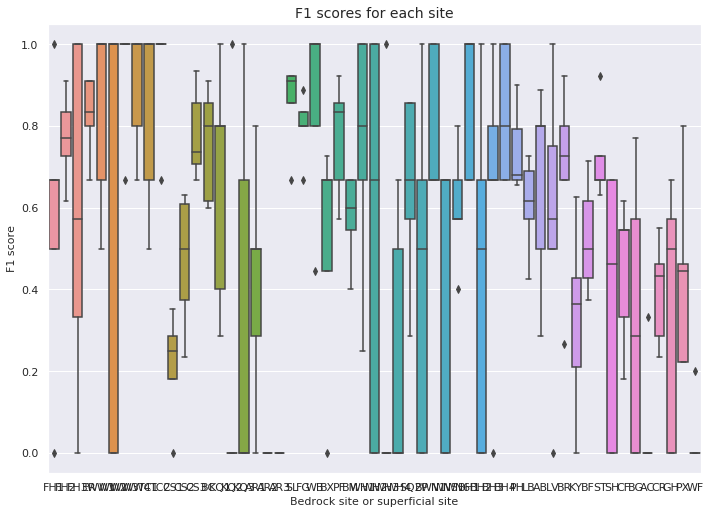

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial site", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/site_specific_f1_scores.png')

In [36]:
if save_plots == True:
    pd.DataFrame(data = f1_df_final.T.median()).to_csv('output/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score with weighted averages

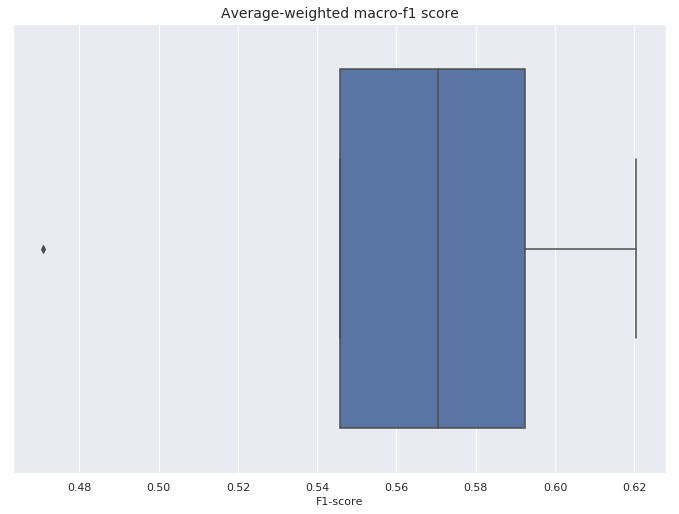

In [37]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/macro_f1_scores.png')

In [39]:
if save_plots == True:
    pd.Series(pd.Series(macro_f1_scores).median()).to_csv('output/median_macro_f1.csv')

### Boxplot showing accuracy scores

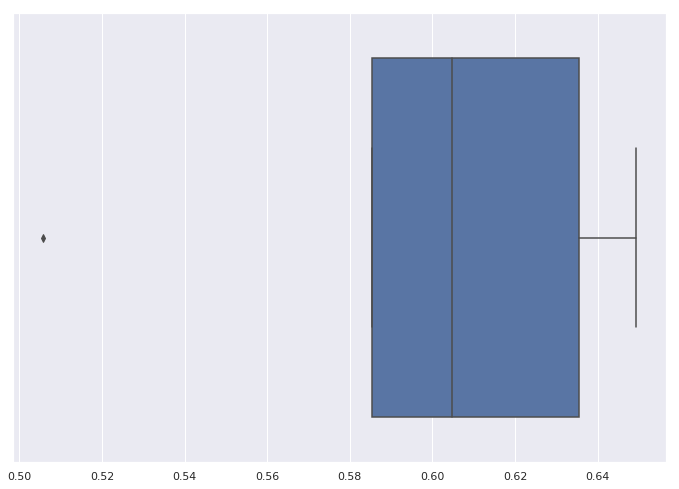

In [40]:
sns.boxplot(accuracy_scores)

### Get feature importances

In [41]:
feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

,round1,round2,round3,round4,round5
0,0.021454,0.021204,0.020781,0.021579,0.021290
1,0.012214,0.012477,0.012677,0.012059,0.012158
2,0.027945,0.029631,0.030207,0.029549,0.027704
3,0.030446,0.033435,0.031817,0.032757,0.032174
4,0.028683,0.028446,0.027811,0.027203,0.027722


In [42]:
feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[my_data.columns.values[9:-1]].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

,round1,round2,round3,round4,round5,element
0,0.021454,0.021204,0.020781,0.021579,0.021290,Li7
1,0.012214,0.012477,0.012677,0.012059,0.012158,Be9
2,0.027945,0.029631,0.030207,0.029549,0.027704,B11
3,0.030446,0.033435,0.031817,0.032757,0.032174,Mg24
4,0.028683,0.028446,0.027811,0.027203,0.027722,Al27


In [43]:
feat_imp_df_final.set_index('element', inplace=True)


In [44]:
feat_imp_df_final_plot = feat_imp_df_final.T

In [45]:
feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

In [46]:
mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

In [47]:
mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

In [48]:
mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

In [49]:
ordered_col_names = list(mean_feature_importance_df['elements'])

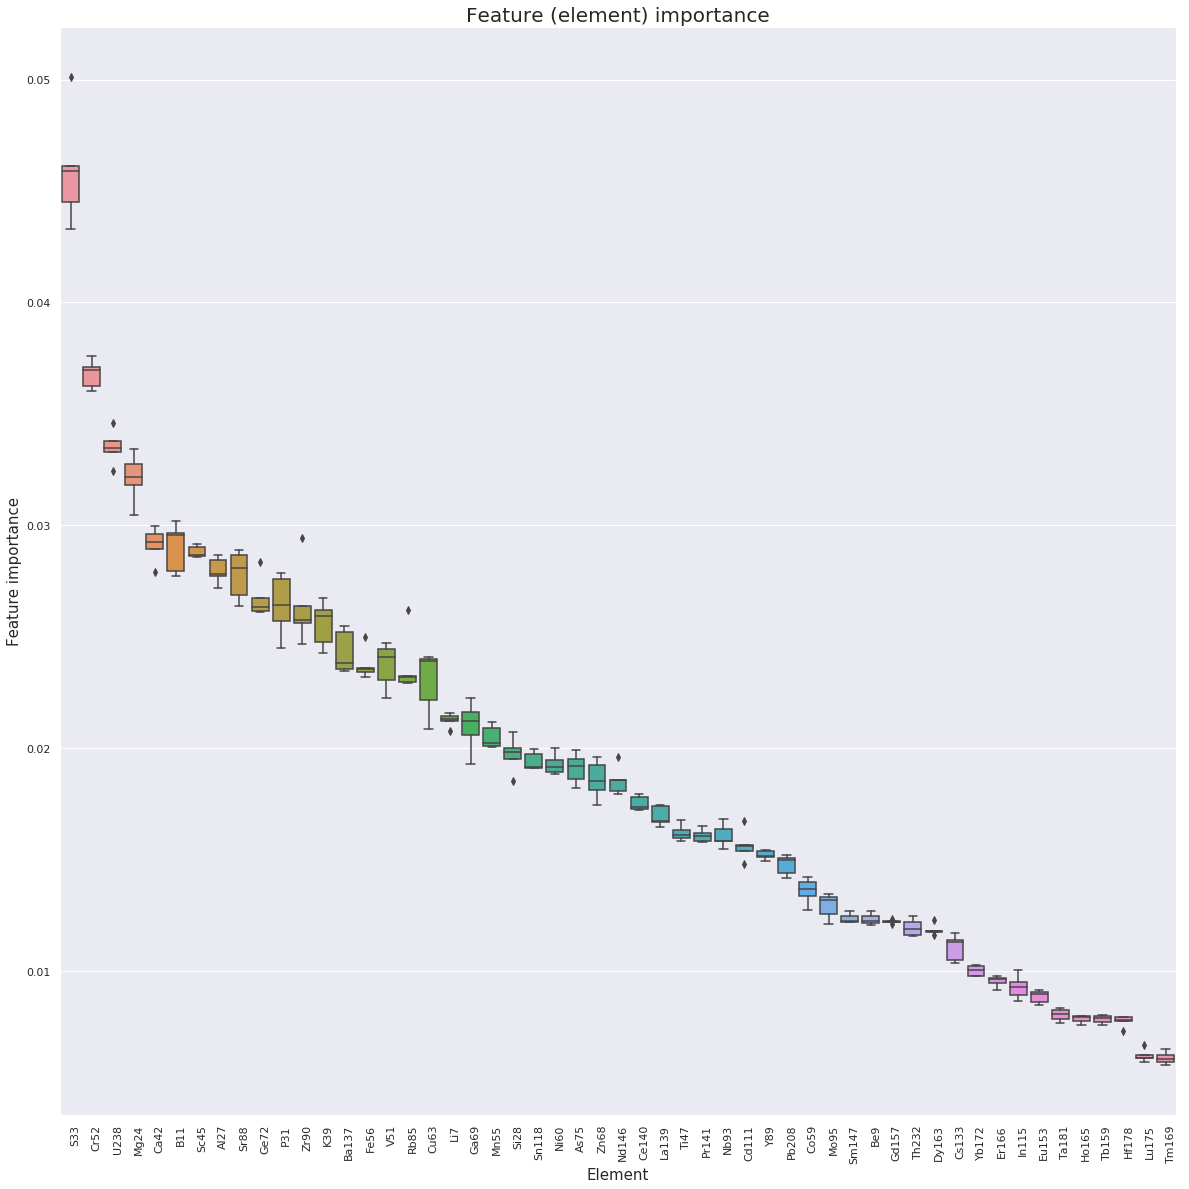

In [50]:
sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/feature_importances.png')

### Model is built for predicting source of artefacts 

In [51]:
RFC_final = RandomForestClassifier(n_estimators=2000, random_state = random_seed_state)

In [52]:
RFC_final.fit(X, y)

KeyboardInterrupt: 

In [ ]:
if pickle_model == True:
    pickle.dump(RFC_final, open('models/' + pickle_model_name + '_' + 'rfc_model.sav', 'wb'))

In [ ]:
print(train_data_formodel['class'].unique())
print(uniques)

In [ ]:
df_for_identifiers = test_data_superficial.copy(deep = True)
identifiers =  df_for_identifiers['Analysis']

### Predictions are made for the artefacts

In [ ]:


test_data_superficial.columns.values[9:-1]

y_pred = RFC_final.predict(np.array(test_data_superficial[test_data.columns.values[9:-1]]))

y_pred_proba = RFC_final.predict_proba(np.array(test_data_superficial[test_data.columns.values[9:-1]]))


In [ ]:
test_data_superficial.head()

In [ ]:
uniques.shape

In [ ]:
probabilities_df = pd.DataFrame(data = y_pred_proba, columns = uniques)
probabilities_df_final = pd.concat([probabilities_df, pd.Series(list(identifiers))], axis = 1)

In [ ]:
probabilities_df_final.rename(columns = {0:'identifier'}, inplace=True)

In [ ]:
final_pred_df = pd.concat([pd.Series(y_pred), probabilities_df_final], axis = 1)

In [ ]:
final_pred_df.rename(columns={0:'class_number'}, inplace = True)

In [ ]:
final_pred_df.to_csv('supertobed_predictions.csv')


In [ ]:
uniques_list = list(uniques)
def get_pred_names(row):
    return(uniques_list[row['class_number']])
final_pred_df['class_predictions'] = final_pred_df.apply(get_pred_names, axis = 1)

In [ ]:
#final_pred_df_modal = final_pred_df.groupby(by = 'class_number')

In [ ]:
final_pred_df.head()